Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/10 | Train Loss: 0.8979113101959229 | Validation Loss: 0.6104481418927511
Epoch 2/10 | Train Loss: 0.5015123753171218 | Validation Loss: 0.7768406867980957
Epoch 3/10 | Train Loss: 0.29724133798950597 | Validation Loss: 0.2895403603712718
Epoch 4/10 | Train Loss: 0.20843847762597234 | Validation Loss: 0.30669230222702026
Epoch 5/10 | Train Loss: 0.07694603914493009 | Validation Loss: 0.9209505120913187
Epoch 6/10 | Train Loss: 0.044253241760950336 | Validation Loss: 0.30845695982376736
Validation loss did not decrease for 3 consecutive epochs. Stopping training...
Test Accuracy for 2 classes: 0.9393939393939394
Test F1 Score for 2 classes: 0.939057239057239
Confusion Matrix:
[[17  0]
 [ 2 14]]


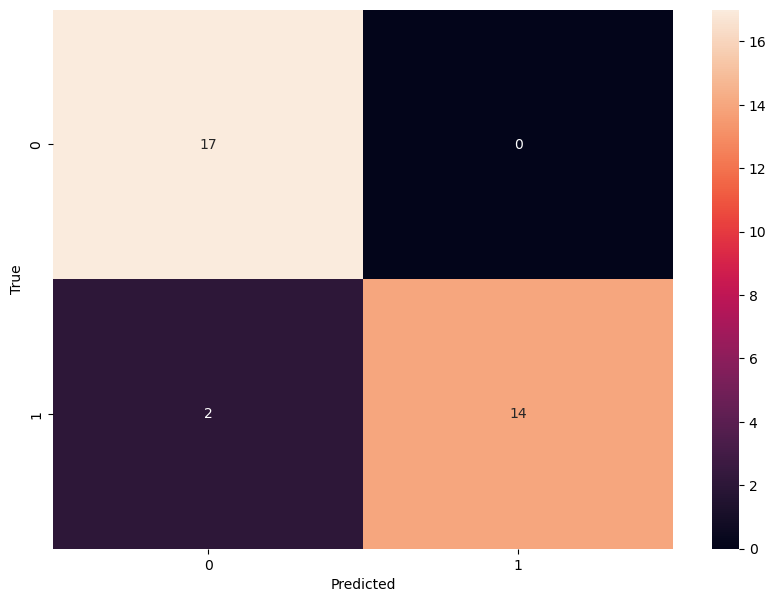

In [1]:
## BERT base model with manually tuning hyperparameters for 2 classes
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def encode_data(tokenizer, texts, labels, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return ComplaintsDataset(encodings, labels)

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Consumer complaint narrative'], df['Label'], test_size=0.3)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_dataset = encode_data(tokenizer, train_texts.tolist(), train_labels.tolist())
val_dataset = encode_data(tokenizer, val_texts.tolist(), val_labels.tolist())
test_dataset = encode_data(tokenizer, test_texts.tolist(), test_labels.tolist())

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10
patience = 3  # Number of epochs to wait for a decrease in validation loss
no_improvement = 0  # Counter to track epochs without improvement
best_val_loss = float('inf')  # Initialize best validation loss

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    # Training phase
    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['labels']

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    # print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss}')

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_labels = val_batch['labels']

            val_outputs = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss} | Validation Loss: {avg_val_loss}')
    
    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'Validation loss did not decrease for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation on the test set
model.eval()
test_predictions = []
test_references = []
with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['labels']
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics and confusion matrix
accuracy_2_classes = accuracy_score(test_references, test_predictions)
f1_2_classes = f1_score(test_references, test_predictions, average='weighted')
confusion_matrix = confusion_matrix(test_references, test_predictions)

print(f"Test Accuracy for 2 classes: {accuracy_2_classes}")
print(f"Test F1 Score for 2 classes: {f1_2_classes}")
print("Confusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/20 | Train Loss: 1.243916031718254 | Validation Loss: 1.1074432134628296
Epoch 2/20 | Train Loss: 1.026956382393837 | Validation Loss: 0.9676404396692911
Epoch 3/20 | Train Loss: 0.8244935601949692 | Validation Loss: 0.8995371460914612
Epoch 4/20 | Train Loss: 0.6211775362491607 | Validation Loss: 0.931546668211619
Epoch 5/20 | Train Loss: 0.421644401550293 | Validation Loss: 0.7524893681208292
Epoch 6/20 | Train Loss: 0.3360065869987011 | Validation Loss: 0.7723674575487772
Epoch 7/20 | Train Loss: 0.2659912846982479 | Validation Loss: 0.8815222382545471
Epoch 8/20 | Train Loss: 0.1440566387027502 | Validation Loss: 0.679803709189097
Epoch 9/20 | Train Loss: 0.10298060812056065 | Validation Loss: 0.7056957383950552
Epoch 10/20 | Train Loss: 0.06793719436973333 | Validation Loss: 0.8880012929439545
Epoch 11/20 | Train Loss: 0.04569886215031147 | Validation Loss: 0.7528251012166342
Validation loss did not decrease for 3 consecutive epochs. Stopping training...
Test Accuracy for 

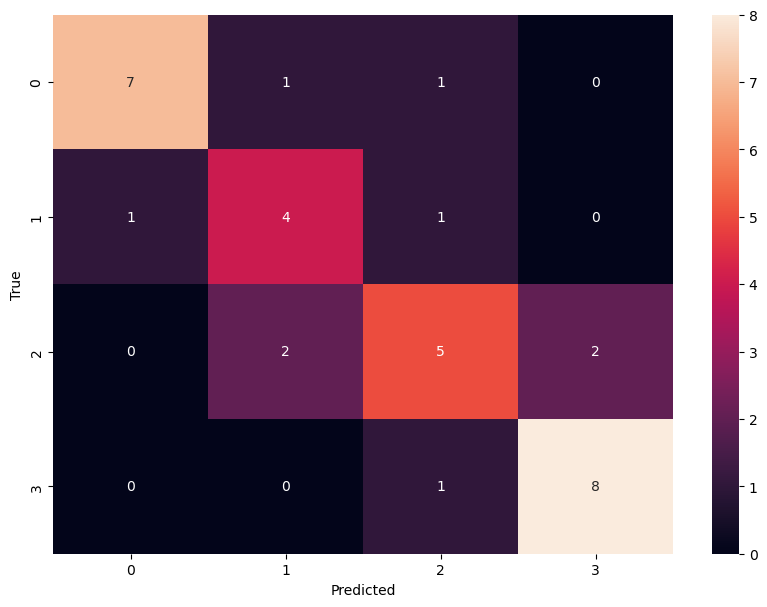

In [3]:
## BERT base model with manually tuning hyperparameters for 4 classes
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def encode_data(tokenizer, texts, labels, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return ComplaintsDataset(encodings, labels)

# Load and preprocess the dataset
file_path = 'complaints-official-4-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Consumer complaint narrative'], df['Label'], test_size=0.3)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_dataset = encode_data(tokenizer, train_texts.tolist(), train_labels.tolist())
val_dataset = encode_data(tokenizer, val_texts.tolist(), val_labels.tolist())
test_dataset = encode_data(tokenizer, test_texts.tolist(), test_labels.tolist())

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 20
patience = 3  # Number of epochs to wait for a decrease in validation loss
no_improvement = 0  # Counter to track epochs without improvement
best_val_loss = float('inf')  # Initialize best validation loss

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    # Training phase
    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['labels']

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    # print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss}')

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_labels = val_batch['labels']

            val_outputs = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss} | Validation Loss: {avg_val_loss}')
    
    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'Validation loss did not decrease for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation on the test set
model.eval()
test_predictions = []
test_references = []
with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['labels']
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics
accuracy_4_classes = accuracy_score(test_references, test_predictions)
f1_4_classes = f1_score(test_references, test_predictions, average='weighted')
confusion_matrix = confusion_matrix(test_references, test_predictions)

print(f"Test Accuracy for 4 classes: {accuracy_4_classes}")
print(f"Test F1 Score for 4 classes: {f1_4_classes}")
print("Confusion Matrix for 4 classes:")
print(confusion_matrix)

# Optional: Visualizing the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaojingzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy for 2 classes: 0.8484848484848485
Test F1 Score for 2 classes: 0.8487641390867198


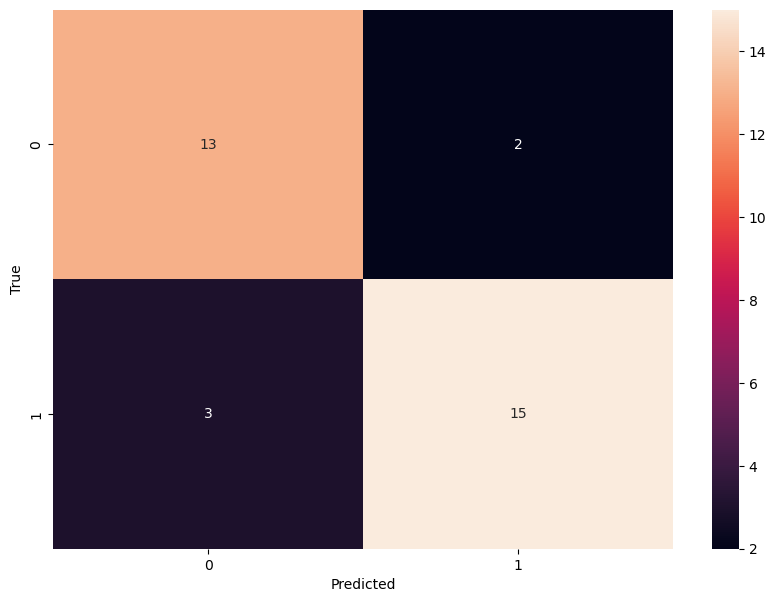

In [20]:
### Use BERT and Manual Features (average length of sentences and domain terms)
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Feature Extraction Function
def extract_features(narratives):
    features = []
    domain_terms = ["credit", "debt", "loan", "score", "report", "financial", "consumer", "account", "law", "act", "reporting", "services", "refund", "card"]
    # domain_terms = ['credit', 'consumer', 'information', 'account', 'report', 'company', 'services', 'debt', 'reporting', 'card', 'law', 'refund', 'financial', 'act', 'loan', 'without', 'also', 'score', 'would']
    
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, labels):
        self.encodings = encodings
        self.features = features
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.tensor(self.features[idx])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Custom BERT Model with Additional Features
class BertWithFeatures(nn.Module):
    def __init__(self, bert_model, feature_dim):
        super(BertWithFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size + feature_dim, 2)  # Assuming binary classification

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_input = torch.cat((pooled_output, features), dim=1)
        logits = self.classifier(combined_input)
        return logits

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'  # Update file path
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Extract features
features = extract_features(df['Consumer complaint narrative'])

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels, train_features, temp_features = train_test_split(
    df['Consumer complaint narrative'], df['Label'], features, test_size=0.3
)
val_texts, test_texts, val_labels, test_labels, val_features, test_features = train_test_split(
    temp_texts, temp_labels, temp_features, test_size=0.5
)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

train_dataset = ComplaintsDataset(train_encodings, train_features, train_labels.tolist())
val_dataset = ComplaintsDataset(val_encodings, val_features, val_labels.tolist())
test_dataset = ComplaintsDataset(test_encodings, test_features, test_labels.tolist())

# Load the BERT model and modify it
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithFeatures(bert_model, feature_dim=2)  # 2 additional features

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10
patience = 3  # Early stopping patience
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        model.zero_grad()

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        loss = nn.CrossEntropyLoss()(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            logits = model(val_input_ids, attention_mask=val_attention_mask, features=val_features)
            val_loss = nn.CrossEntropyLoss()(logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print('Stopping early due to no improvement in validation loss.')
            break

# Evaluation
model.eval()
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 2 classes: {accuracy}')
print(f'Test F1 Score for 2 classes: {f1}')

# Confusion Matrix
conf_matrix = sk_confusion_matrix(test_references, test_predictions)  # Use the renamed function
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaojingzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss: 0.5178209778509641 | Validation Loss: 0.4388516346613566
Epoch 2/10 | Train Loss: 0.3118405749923305 | Validation Loss: 0.43841448922952014
Epoch 3/10 | Train Loss: 0.2250227641902472 | Validation Loss: 0.30798940112193424
Epoch 4/10 | Train Loss: 0.11976256515634687 | Validation Loss: 0.16676007707913718
Epoch 5/10 | Train Loss: 0.053058467903419546 | Validation Loss: 0.16689059945444265
Epoch 6/10 | Train Loss: 0.021371296950076755 | Validation Loss: 0.19928745118280253
Epoch 7/10 | Train Loss: 0.014282104951378546 | Validation Loss: 0.21130441625912985
No improvement in validation loss for 3 consecutive epochs. Stopping training...
Test Accuracy: 0.8787878787878788
Test F1 Score: 0.8809523809523809


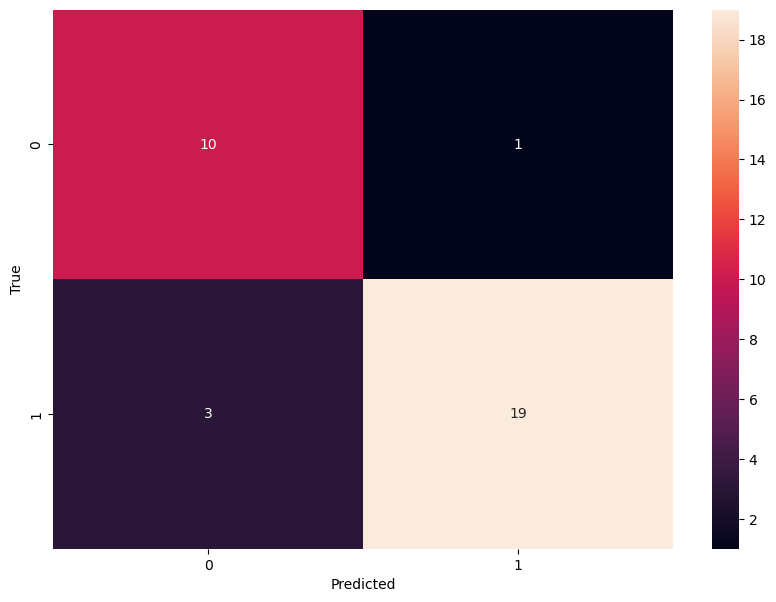

In [19]:
### Use BERT and Manual Features (TF-IDF)
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Feature Extraction Function
def extract_features(narratives):
    features = []
    domain_terms = ["credit", "debt", "loan", "score", "report", "financial", "consumer", "account", "law", "act", "reporting", "services", "refund", "card"]
    # domain_terms = ['credit', 'consumer', 'information', 'account', 'report', 'company', 'services', 'debt', 'reporting', 'card', 'law', 'refund', 'financial', 'act', 'loan', 'without', 'also', 'score', 'would']
    
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

# Custom Dataset Class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.cat((torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Custom BERT Model with Additional Features
class BertWithFeatures(nn.Module):
    def __init__(self, bert_model, feature_dim, tfidf_feature_dim):
        super(BertWithFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size + feature_dim + tfidf_feature_dim, 2)  # Binary classification

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_input = torch.cat((pooled_output, features), dim=1)
        logits = self.classifier(combined_input)
        return logits

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Extract manual features
manual_features = extract_features(df['Consumer complaint narrative'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_texts, temp_texts, train_labels, temp_labels, train_manual_features, temp_manual_features = train_test_split(
    df['Consumer complaint narrative'], df['Label'], manual_features, test_size=0.3
)
val_texts, test_texts, val_labels, test_labels, val_manual_features, test_manual_features = train_test_split(
    temp_texts, temp_labels, temp_manual_features, test_size=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
val_tfidf = tfidf_vectorizer.transform(val_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

train_dataset = ComplaintsDataset(train_encodings, train_manual_features, train_tfidf, train_labels.tolist())
val_dataset = ComplaintsDataset(val_encodings, val_manual_features, val_tfidf, val_labels.tolist())
test_dataset = ComplaintsDataset(test_encodings, test_manual_features, test_tfidf, test_labels.tolist())

# Load the BERT model and modify it
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithFeatures(bert_model, feature_dim=len(train_manual_features[0]), tfidf_feature_dim=500)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop with early stopping
num_epochs = 10
patience = 3
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        model.zero_grad()

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        loss = nn.CrossEntropyLoss()(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            logits = model(val_input_ids, attention_mask=val_attention_mask, features=val_features)
            val_loss = nn.CrossEntropyLoss()(logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation
model.eval()
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy: {accuracy}')
print(f'Test F1 Score: {f1}')

# Confusion Matrix
conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaojingzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/10 | Train Loss: 1.321020558476448 | Validation Loss: 0.980323056379954
Epoch 2/10 | Train Loss: 0.9414117962121964 | Validation Loss: 0.9348113338152567
Epoch 3/10 | Train Loss: 0.7824875950813294 | Validation Loss: 0.6713332136472067
Epoch 4/10 | Train Loss: 0.6729215458035469 | Validation Loss: 0.7099041740099589
Epoch 5/10 | Train Loss: 0.562797449529171 | Validation Loss: 0.5585739314556122
Epoch 6/10 | Train Loss: 0.40411618277430533 | Validation Loss: 0.48727066318194073
Epoch 7/10 | Train Loss: 0.3046790663152933 | Validation Loss: 0.44815204044183093
Epoch 8/10 | Train Loss: 0.20225339457392694 | Validation Loss: 0.45877201358477276
Epoch 9/10 | Train Loss: 0.2511885862797499 | Validation Loss: 0.35505684713522595
Epoch 10/10 | Train Loss: 0.17784027978777886 | Validation Loss: 0.5432440489530563
Test Accuracy for 4 classes: 0.8181818181818182
Test F1 Score for 4 classes: 0.810966810966811


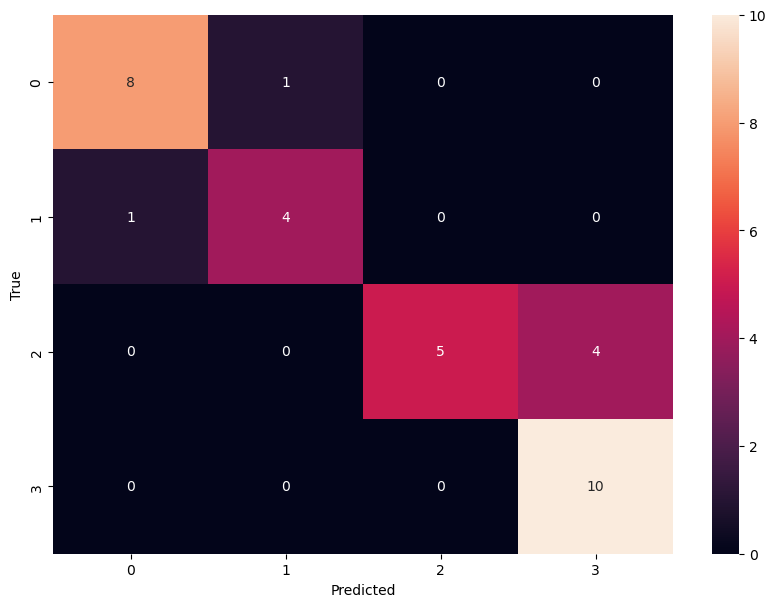

In [18]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Feature Extraction Function
def extract_features(narratives):
    features = []
    domain_terms = [
        "money", "help",  # Class 0: Basic terms
        "credit", "account", "paid", "debt", "card",  # Class 1: Basic financial terms
        "loan", "financial", "consumer", "payment", "service",  # Class 2: Moderate understanding
        "reporting", "act", "law", "unauthorized", "section", "usc", "rights"  # Class 3: Advanced terms
    ]
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

# Custom Dataset Class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.cat((torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Custom BERT Model with Additional Features for 4-class classification
class BertWithFeatures(nn.Module):
    def __init__(self, bert_model, feature_dim, tfidf_feature_dim):
        super(BertWithFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size + feature_dim + tfidf_feature_dim, 4)  # 4-class classification

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_input = torch.cat((pooled_output, features), dim=1)
        logits = self.classifier(combined_input)
        return logits

# Load and preprocess the dataset
file_path = 'complaints-official-4-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Extract manual features
manual_features = extract_features(df['Consumer complaint narrative'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_texts, temp_texts, train_labels, temp_labels, train_manual_features, temp_manual_features = train_test_split(
    df['Consumer complaint narrative'], df['Label'], manual_features, test_size=0.3
)
val_texts, test_texts, val_labels, test_labels, val_manual_features, test_manual_features = train_test_split(
    temp_texts, temp_labels, temp_manual_features, test_size=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
val_tfidf = tfidf_vectorizer.transform(val_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

train_dataset = ComplaintsDataset(train_encodings, train_manual_features, train_tfidf, train_labels.tolist())
val_dataset = ComplaintsDataset(val_encodings, val_manual_features, val_tfidf, val_labels.tolist())
test_dataset = ComplaintsDataset(test_encodings, test_manual_features, test_tfidf, test_labels.tolist())

# Load the BERT model and modify it for 4-class classification
model = BertWithFeatures(bert_model, feature_dim=len(train_manual_features[0]), tfidf_feature_dim=500)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop with early stopping for 4-class classification
num_epochs = 10
patience = 3
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        model.zero_grad()

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        loss = nn.CrossEntropyLoss()(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            logits = model(val_input_ids, attention_mask=val_attention_mask, features=val_features)
            val_loss = nn.CrossEntropyLoss()(logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation for 4-class classification
model.eval()
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics for 4-class classification
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 4 classes: {accuracy}')
print(f'Test F1 Score for 4 classes: {f1}')

# Confusion Matrix for 4-class classification
conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaojingzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss: 0.6657513756501047 | Validation Loss: 0.48943185806274414
Epoch 2/10 | Train Loss: 0.497220084855431 | Validation Loss: 0.43205637733141583
Epoch 3/10 | Train Loss: 0.336364498656047 | Validation Loss: 0.32726261764764786
Epoch 4/10 | Train Loss: 0.16763582551165632 | Validation Loss: 0.30946059897542
Epoch 5/10 | Train Loss: 0.09782789882860686 | Validation Loss: 0.2575877147416274
Epoch 6/10 | Train Loss: 0.036901437481375116 | Validation Loss: 0.3645458836108446
Epoch 7/10 | Train Loss: 0.018692482262849808 | Validation Loss: 0.4477214296348393
Epoch 8/10 | Train Loss: 0.01023678932535021 | Validation Loss: 0.4827306675724685
No improvement in validation loss for 3 consecutive epochs. Stopping training...
Test Accuracy for 2 classes: 0.8787878787878788
Test F1 Score for 2 classes: 0.8799270904534062


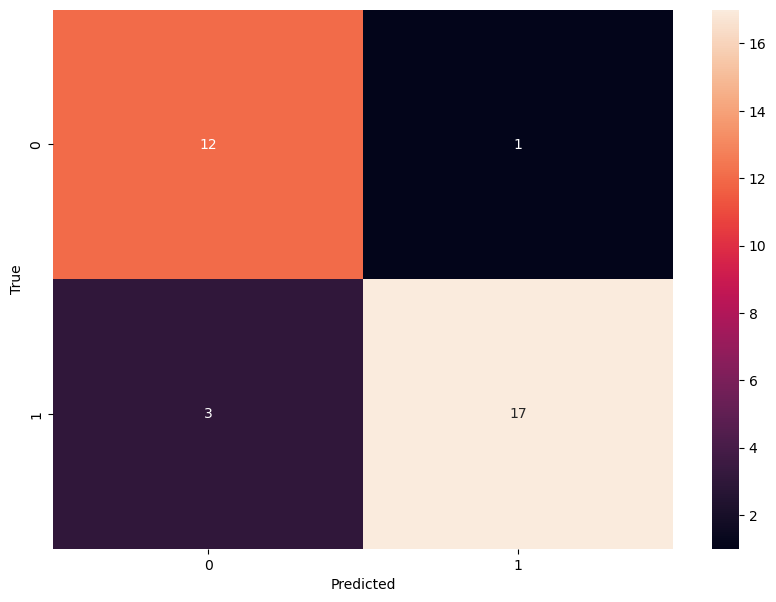

In [27]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Feature Extraction Function
def extract_features(narratives):
    features = []
    domain_terms = ["credit", "debt", "loan", "score", "report", "financial", "consumer", 
                    "account", "law", "act", "reporting", "services", "refund", "card"]
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

# Custom Dataset Class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.cat((torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Custom BERT Model with Additional Features for 2-class classification
class BertWithFeatures(nn.Module):
    def __init__(self, bert_model, feature_dim, tfidf_feature_dim):
        super(BertWithFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size + feature_dim + tfidf_feature_dim, 2) 

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_input = torch.cat((pooled_output, features), dim=1)
        logits = self.classifier(combined_input)
        return logits

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Manually extract features
manual_features = extract_features(df['Consumer complaint narrative'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_texts, temp_texts, train_labels, temp_labels, train_manual_features, temp_manual_features = train_test_split(
    df['Consumer complaint narrative'], df['Label'], manual_features, test_size=0.3
)
val_texts, test_texts, val_labels, test_labels, val_manual_features, test_manual_features = train_test_split(
    temp_texts, temp_labels, temp_manual_features, test_size=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
val_tfidf = tfidf_vectorizer.transform(val_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

train_dataset = ComplaintsDataset(train_encodings, train_manual_features, train_tfidf, train_labels.tolist())
val_dataset = ComplaintsDataset(val_encodings, val_manual_features, val_tfidf, val_labels.tolist())
test_dataset = ComplaintsDataset(test_encodings, test_manual_features, test_tfidf, test_labels.tolist())

# Load the BERT model and modify it for 2-class classification
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithFeatures(bert_model, feature_dim=len(train_manual_features[0]), tfidf_feature_dim=500)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop with early stopping for 2-class classification
num_epochs = 10
patience = 3
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        model.zero_grad()

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        loss = nn.CrossEntropyLoss()(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            logits = model(val_input_ids, attention_mask=val_attention_mask, features=val_features)
            val_loss = nn.CrossEntropyLoss()(logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation for 2-class classification
model.eval()
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics for 2-class classification
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 2 classes: {accuracy}')
print(f'Test F1 Score for 2 classes: {f1}')

# Confusion Matrix for 2-class classification
conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Feature Extraction Function
def extract_features(narratives):
    features = []
    domain_terms = ["credit", "debt", "loan", "score", "report", "financial", "consumer", 
                    "account", "law", "act", "reporting", "services", "refund", "card"]
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

# Custom Dataset Class
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['features'] = torch.cat((torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Custom BERT Model with Additional Features for 2-class classification
class BertWithFeatures(nn.Module):
    def __init__(self, bert_model, feature_dim, tfidf_feature_dim):
        super(BertWithFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size + feature_dim + tfidf_feature_dim, 2) 

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_input = torch.cat((pooled_output, features), dim=1)
        logits = self.classifier(combined_input)
        return logits

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Manually extract features
manual_features = extract_features(df['Consumer complaint narrative'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_texts, temp_texts, train_labels, temp_labels, train_manual_features, temp_manual_features = train_test_split(
    df['Consumer complaint narrative'], df['Label'], manual_features, test_size=0.3
)
val_texts, test_texts, val_labels, test_labels, val_manual_features, test_manual_features = train_test_split(
    temp_texts, temp_labels, temp_manual_features, test_size=0.5
)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
val_tfidf = tfidf_vectorizer.transform(val_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

train_dataset = ComplaintsDataset(train_encodings, train_manual_features, train_tfidf, train_labels.tolist())
val_dataset = ComplaintsDataset(val_encodings, val_manual_features, val_tfidf, val_labels.tolist())
test_dataset = ComplaintsDataset(test_encodings, test_manual_features, test_tfidf, test_labels.tolist())

# Load the BERT model and modify it for 2-class classification
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithFeatures(bert_model, feature_dim=len(train_manual_features[0]), tfidf_feature_dim=500)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop with early stopping for 2-class classification
num_epochs = 100
patience = 5
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        model.zero_grad()

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        loss = nn.CrossEntropyLoss()(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            logits = model(val_input_ids, attention_mask=val_attention_mask, features=val_features)
            val_loss = nn.CrossEntropyLoss()(logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation for 2-class classification
model.eval()
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = model(batch_input_ids, attention_mask=batch_attention_mask, features=batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

# Calculate test set metrics for 2-class classification
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 2 classes: {accuracy}')
print(f'Test F1 Score for 2 classes: {f1}')

# Confusion Matrix for 2-class classification
conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()